In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def PxPyPzE(jets):
    # jets: 一個形狀為 (n, 4) 的 NumPy 陣列，其中 n 是噴射數量，每個噴射有四個屬性（pt, eta, phi, m）
    pt, eta, phi, m = jets.T

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    e = np.sqrt(m*m + px*px + py*py + pz*pz)

    return px.sum(), py.sum(), pz.sum(), e.sum()

def PtEtaPhiM(px, py, pz, e):

    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1/2 * np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(e**2 - px**2 - py**2 - pz**2)

    return pt, eta, phi, m

In [3]:
file_path = '/home/r10222035/SPANet2/data/triHiggs/gghhh_4b_PT40_3h_train.h5'

with h5py.File(file_path, 'r') as f:

    nevent = f['INPUTS/Source/pt'].shape[0]
    # nevent = 1000
    m_higgs = [[], [], []]
    for event in tqdm(range(nevent)):
 
        pt = f['INPUTS/Source/pt'][event]
        eta = f['INPUTS/Source/eta'][event]
        phi = f['INPUTS/Source/phi'][event]
        mass = f['INPUTS/Source/mass'][event]

        
        h1_b1 = f['TARGETS/h1/b1'][event] 
        h1_b2 = f['TARGETS/h1/b2'][event] 
        h2_b1 = f['TARGETS/h2/b1'][event] 
        h2_b2 = f['TARGETS/h2/b2'][event] 
        h3_b1 = f['TARGETS/h3/b1'][event] 
        h3_b2 = f['TARGETS/h3/b2'][event] 


        true_pair = np.array([h1_b1,h1_b2, h2_b1,h2_b2, h3_b1,h3_b2])
        if (true_pair == -1).all():
            continue
     
        jets = np.array([[pt[i], eta[i], phi[i], mass[i]] for i in true_pair])

        pt1, _, _, mh1 = PtEtaPhiM(*PxPyPzE(jets[[0, 1]]))
        pt2, _, _, mh2 = PtEtaPhiM(*PxPyPzE(jets[[2, 3]]))
        pt3, _, _, mh3 = PtEtaPhiM(*PxPyPzE(jets[[4, 5]]))

        pt_mh_pairs = sorted(zip([pt1, pt2, pt3], [mh1, mh2, mh3]))
        pt_sorted, mh_sorted = zip(*pt_mh_pairs)

        mh1, mh2, mh3 = mh_sorted[::-1]
        m_higgs[0].append(mh1)
        m_higgs[1].append(mh2)
        m_higgs[2].append(mh3)


100%|██████████| 280788/280788 [11:48<00:00, 396.58it/s]


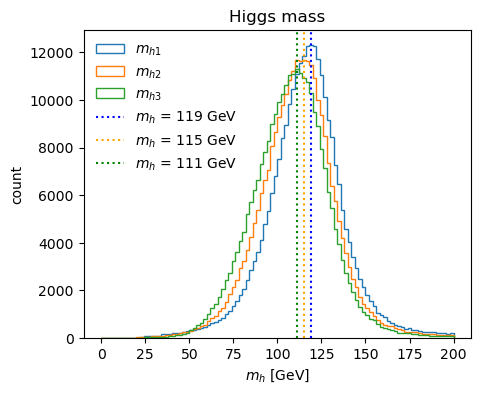

In [6]:
# plot Higgs mass distribution

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

for i in range(3):
    ax.hist(m_higgs[i], bins=100, histtype='step',range=(0, 200), label=f'$m_{{h{i+1}}}$')
    ax.set_title(f'Higgs mass')
    ax.set_xlabel('$m_h$ [GeV]')
    ax.set_ylabel('count')

# plot vertical lines
mh = [119, 115, 111]
ax.axvline(mh[0], color='b', linestyle=':', label=f'$m_h$ = {mh[0]} GeV')
ax.axvline(mh[1], color='orange', linestyle=':', label=f'$m_h$ = {mh[1]} GeV')
ax.axvline(mh[2], color='g', linestyle=':', label=f'$m_h$ = {mh[2]} GeV')

ax.legend(frameon=False, loc='upper left')

plt.savefig('./figures/mh_distribution_new.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()